In [ ]:
import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import albumentations as A


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset"
train_path = os.path.join(dataset_path, "train/")

In [ ]:
a = np.load(dataset_path + '/x_train.npz')['data']
b = np.load(dataset_path + '/y_train.npz')['data']
b = b[:, :, :, 1]

In [ ]:
a.shape

(12706, 256, 256, 3)

In [ ]:
image_transform = A.Compose(
    [

        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.2,  border_mode=cv2.BORDER_CONSTANT),
        # A.RandomCrop(height=256, width=256, p=0.5),
#         A.augmentations.crops.transforms.CenterCrop(),
        A.Crop  (x_min=12, y_min=10, x_max=240, y_max=180, always_apply=False, p=0.5),
        A.Resize(256,256),

        # A.IAAAdditiveGaussianNoise(p=0.2),
        # # A.IAAPerspective(p=0.5),

        # A.OneOf(
        #     [
        #         A.CLAHE(p=1),
        #         A.RandomBrightness(p=1),
        #         A.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

#         A.OneOf(
#             [
#                 A.IAASharpen(p=1),
#                 A.Blur(blur_limit=3, p=1),
#                 A.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

        # A.OneOf(
        #     [
        #         A.RandomContrast(p=1),
        #         A.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # )
    ]
)

In [ ]:
print(len(a))
print(int(len(a)/float(8)))
print(1588*8)

12706
1588
12704


In [ ]:
class DataSet(keras.utils.Sequence):

  def __init__(self, images, masks, augmentation=None, transforms=None,  shape = (256, 256), outShape= (256, 256), batch_size = 32):
    self.images = images
    self.masks = masks
    self.augmentation = augmentation
    self.transforms = transforms
    self.shape = shape
    self.outshape = outShape
    self.batch_size = batch_size

  def __len__(self):
    # round down (drop last batch)
    return int(len(self.images)/float(self.batch_size))
  
  def __getitem__(self, index):

    batch_index = index * self.batch_size
    assert batch_index + self.batch_size < len(self.images), f"{batch_index + self.batch_siz} total size is {len(self.images)} assert"

    images = []
    masks = []

    for i in range(batch_index, batch_index + self.batch_size):
      image = cv2.resize(self.images[i], self.shape, cv2.INTER_AREA)
      mask = cv2.resize(self.masks[i], self.outshape, cv2.INTER_AREA)

      if self.augmentation != None:
        aug = self.augmentation(image= image, mask = mask)
        image = aug['image']
        mask = aug['mask']
  
      if self.transforms != None:
        image = self.transforms(image)
        mask = self.transforms(mask)

      images.append(image)
      masks.append(mask)
      # print("in aug", i)

    return np.array(images), np.array(masks)



In [ ]:

val_split = int(len(a) * 0.8)
train_dataset = DataSet(a[:val_split], b[:val_split], augmentation=image_transform, batch_size=8)
test_dataset = DataSet(a[val_split:], b[val_split:])

0
1
2
3
4
5


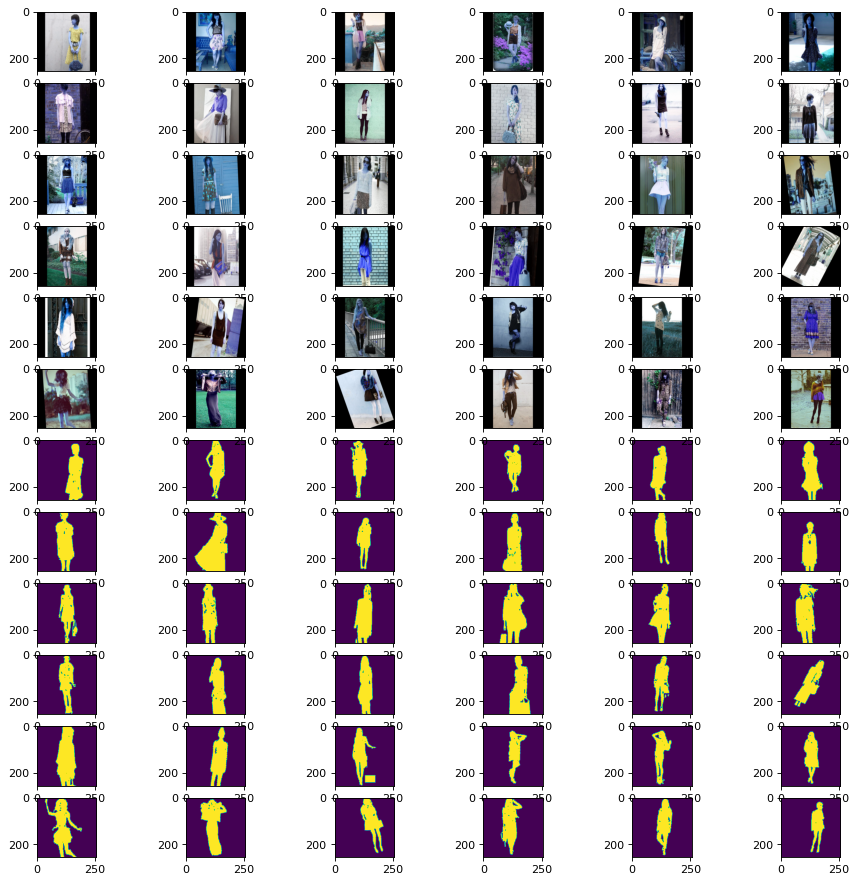

In [ ]:
row = 6
plt.figure(figsize=(14, 14), dpi=80)
for i in range(row):
#     if i +11 < row**2:
        counter = 0
        print(i)
        # for image, mask in train_dataset:
        image, mask = train_dataset.__getitem__(i)
        for j in range(row):
            plt.subplot(row*2,row,i*(row)+counter+1)
            # print(j,i*(row)+counter+1, i*(row)+counter+1+ 36)
            plt.imshow(image[j])
            plt.subplot(row*2,row,i*(row)+counter+1+ 36)
            # print(np.array(image).shape, np.array(mask).shape)
            plt.imshow(mask[j])
#             assert image[i].permute(1,2,0).shape != (352, 352)
#             print('a',i*(row+1)+counter+1+ 35)
            counter += 1
#             print(i*row)
            if counter >=row:
#                 counter =0
# #                 i +=1
#                 if i == 6:
#                     break
                break
                
plt.show()

In [ ]:
# batch Normalization --> activation
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

# batch Normalization --> activation --> Convolution
def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

# conv_block  + Identity Mapping (Conv(1x1) + BN)
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

# conv_block x2 + Identity Mapping (Conv(1x1) + BN)
def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

# upsample + concatenation
def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet():
    filters = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, filters[0])
    e2 = residual_block(e1, filters[1], strides=2)
    e3 = residual_block(e2, filters[2], strides=2)
    e4 = residual_block(e3, filters[3], strides=2)
    e5 = residual_block(e4, filters[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, filters[4], strides=1)
    b1 = conv_block(b0, filters[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, filters[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, filters[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, filters[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, filters[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
val_split = int(len(a) * 0.8)
train_dataset = tf.data.Dataset.from_tensor_slices((a[:val_split], b[:val_split]))
test_dataset = tf.data.Dataset.from_tensor_slices((a[val_split:], b[val_split:]))

In [ ]:
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for x,y in train_dataset:
  print(x.shape, y.shape)
  break

(8, 256, 256, 3) (8, 256, 256)


In [ ]:
image_size = 256

model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
epochs = 10

model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
318/318 [==============================] - 657s 2s/step - loss: 0.1557 - dice_coef: 0.8443 - val_loss: 0.1248 - val_dice_coef: 0.8752
Epoch 2/10
318/318 [==============================] - 614s 2s/step - loss: 0.1051 - dice_coef: 0.8949 - val_loss: 0.1016 - val_dice_coef: 0.8984
Epoch 3/10
318/318 [==============================] - 613s 2s/step - loss: 0.0885 - dice_coef: 0.9115 - val_loss: 0.1072 - val_dice_coef: 0.8929
Epoch 4/10
318/318 [==============================] - 614s 2s/step - loss: 0.0782 - dice_coef: 0.9219 - val_loss: 0.0853 - val_dice_coef: 0.9146
Epoch 5/10
318/318 [==============================] - 614s 2s/step - loss: 0.0698 - dice_coef: 0.9303 - val_loss: 0.0810 - val_dice_coef: 0.9190
Epoch 6/10
318/318 [==============================] - 614s 2s/step - loss: 0.0636 - dice_coef: 0.9364 - val_loss: 0.0658 - val_dice_coef: 0.9342
Epoch 7/10
318/318 [==============================] - 614s 2s/step - loss: 0.0581 - dice_coef: 0.9419 - val_loss: 0.0642 - val_dic

In [ ]:
model.save('/content/drive/MyDrive/Kaggle/ResUnet')

INFO:tensorflow:Assets written to: content/drive/MyDrive/Kaggle/ResUnet/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ResUnet', compile=False)

In [ ]:
import cv2

image = cv2.imread('/content/drive/MyDrive/test_data/'+ 'download.png')
image = cv2.resize(image, (256, 256), cv2.INTER_AREA)

In [ ]:
out = model(image[None,:,:,:], training=False)
mask = out.numpy().reshape((256,256))

In [ ]:
print(out.shape)
print(type(out))

(1, 256, 256, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


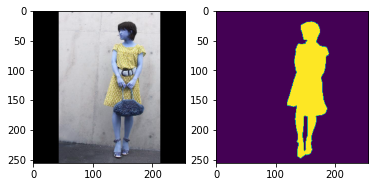

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(out.numpy().reshape((256,256)))
plt.show()

In [ ]:
print(image.shape, mask.shape)

(256, 256, 3) (256, 256)


In [ ]:
from PIL import Image
def apply_mask(image, mask, size=(276, 183)):  
  # if type(mask) == torch.Tensor:
  #   mask = Image.fromarray(mask.detach().numpy().squeeze().squeeze().astype(np.uint8))

  if type(image) == np.ndarray:
    image = Image.fromarray(image)
    print(image.size)
  if type(mask) == np.ndarray:
    mask = Image.fromarray(mask)
    print(mask.size)
  # x, y = image.size
  plt.imshow(Image.composite(image , Image.new('RGBA', size, (0,0,225)), mask=mask))

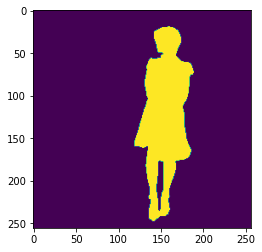

In [ ]:
plt.imshow(np.where(mask >0.5, 1, 0))
m2 = np.where(mask >0.5, 1, 0)

(256, 256, 3) (256, 256, 3)


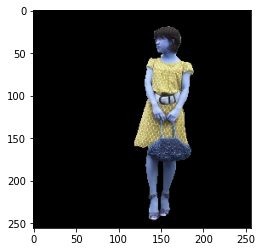

In [ ]:
result = m2[:,:,None] * image 
result2 = (1 - m2[:,:,None]) * image
print(result.shape, result2.shape)
plt.imshow(result)